In [9]:
import tensorflow as tf
import pandas as pd
import os
from sklearn.model_selection import train_test_split

image_size = (224, 224)  
batch_size = 32          

csv_file = "../data/cells/dataset.csv"  
image_dir = "../data/cells/"      

df = pd.read_csv(csv_file)

df['image_path'] = df['Filename'].apply(lambda x: os.path.join(image_dir, x))

train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

df

,Site,Figure,Color,Filename,image_path
0,chessarena,bishop,black,chessarena_black_bishop_on_black.png,../data/cells/chessarena_black_bishop_on_black...
1,chessarena,bishop,black,chessarena_black_bishop_on_white.png,../data/cells/chessarena_black_bishop_on_white...
2,chessarena,bishop,black,chessarena_black_bishop_selected.png,../data/cells/chessarena_black_bishop_selected...
3,chessarena,king,black,chessarena_black_king_check.png,../data/cells/chessarena_black_king_check.png
4,chessarena,king,black,chessarena_black_king_checkmate.png,../data/cells/chessarena_black_king_checkmate.png
...,...,...,...,...,...
169,lichess,queen,white,lichess_white_queen_on_white_selected.png,../data/cells/lichess_white_queen_on_white_sel...
170,lichess,rook,white,lichess_white_rook_on_black.png,../data/cells/lichess_white_rook_on_black.png
171,lichess,rook,white,lichess_white_rook_on_black_selected.png,../data/cells/lichess_white_rook_on_black_sele...
172,lichess,rook,white,lichess_white_rook_on_white.png,../data/cells/lichess_white_rook_on_white.png


In [10]:
def preprocess_image(file_path, label_figure, label_color):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = img / 255.0  

    return img, (label_figure, label_color)


def create_dataset(dataframe):
    file_paths = dataframe['image_path'].values
    figure_labels = dataframe['Figure'].map(figure_to_label).values
    color_labels = dataframe['Color'].map(color_to_label).values
    
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, figure_labels, color_labels))
    dataset = dataset.map(lambda x, y, z: preprocess_image(x, y, z), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    
    return dataset


In [11]:
figure_to_label = {figure: idx for idx, figure in enumerate(df['Figure'].unique())}
color_to_label = {color: idx for idx, color in enumerate(df['Color'].unique())}

train_dataset = create_dataset(train_df)
test_dataset = create_dataset(test_df)



In [12]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, Recall

def create_custom_model(input_shape, num_figures, num_colors):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    #TODO убрать dropout
    x = layers.Dropout(0.5)(x)

    figure_output = layers.Dense(num_figures, activation='softmax', name='figure')(x)
    color_output = layers.Dense(num_colors, activation='softmax', name='color')(x)
    model = models.Model(inputs=inputs, outputs=[figure_output, color_output])
    return model

input_shape = (224, 224, 3)  
num_figures = len(figure_to_label) 
num_colors = len(color_to_label)   

In [13]:
    
model = create_custom_model(input_shape, num_figures, num_colors)

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={
        'figure': 'sparse_categorical_crossentropy', 
        'color': 'sparse_categorical_crossentropy'
    },
    metrics={
        'figure': ['accuracy'],  
        'color': ['accuracy'],
    }
)

model.summary()

history = model.fit(train_dataset, epochs=15, validation_data=test_dataset)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 222, 222,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 111, 111,  │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 54, 54,    │          0 │ conv2d_5[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 52, 52,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 26, 26,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 24, 24,    │    147,584 │ max_pooling2d_6[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 12, 12,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 18432)     │          0 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │  4,718,848 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ figure (Dense)      │ (None, 8)         │      2,056 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ color (Dense)       │ (None, 3)         │        771 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,962,507 (18.93 MB)

 Trainable params: 4,962,507 (18.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 309ms/step - color_accuracy: 0.4431 - color_loss: 1.0150 - figure_accuracy: 0.1517 - figure_loss: 2.1211 - loss: 3.1413 - val_color_accuracy: 0.4286 - val_color_loss: 0.7558 - val_figure_accuracy: 0.1714 - val_figure_loss: 2.1551 - val_loss: 2.7494
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - color_accuracy: 0.5691 - color_loss: 0.8808 - figure_accuracy: 0.1365 - figure_loss: 2.0711 - loss: 2.9598 - val_color_accuracy: 0.9143 - val_color_loss: 0.5922 - val_figure_accuracy: 0.2286 - val_figure_loss: 1.9713 - val_loss: 2.4562
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 276ms/step - color_accuracy: 0.7592 - color_loss: 0.7339 - figure_accuracy: 0.2847 - figure_loss: 1.9171 - loss: 2.6524 - val_color_accuracy: 0.9714 - val_color_loss: 0.3849 - val_figure_accuracy: 0.3143 - val_figure_loss: 1.9388 - val_loss: 2.1393
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 425ms/step - color_accuracy: 0.8179 - color_loss: 0.5747 - figure_accuracy: 0.3877 - figure_loss:

In [14]:
model.save('../models/model_figures.h5')

In [15]:


# train_precision = history.history.get('precision', None)  
# val_precision = history.history.get('val_precision', None)  
# 
# train_recall = history.history.get('recall', None) 
# val_recall = history.history.get('val_recall', None) 


train_color_loss = history.history['color_loss']
val_color_loss = history.history['val_color_loss']

train_color_accuracy= history.history['color_accuracy']
val_color_accuracy= history.history['val_color_accuracy']


train_figure_loss= history.history['figure_loss']
val_figure_loss= history.history['val_figure_loss']

train_figure_accuracy= history.history['figure_accuracy']
val_figure_accuracy= history.history['val_figure_accuracy']




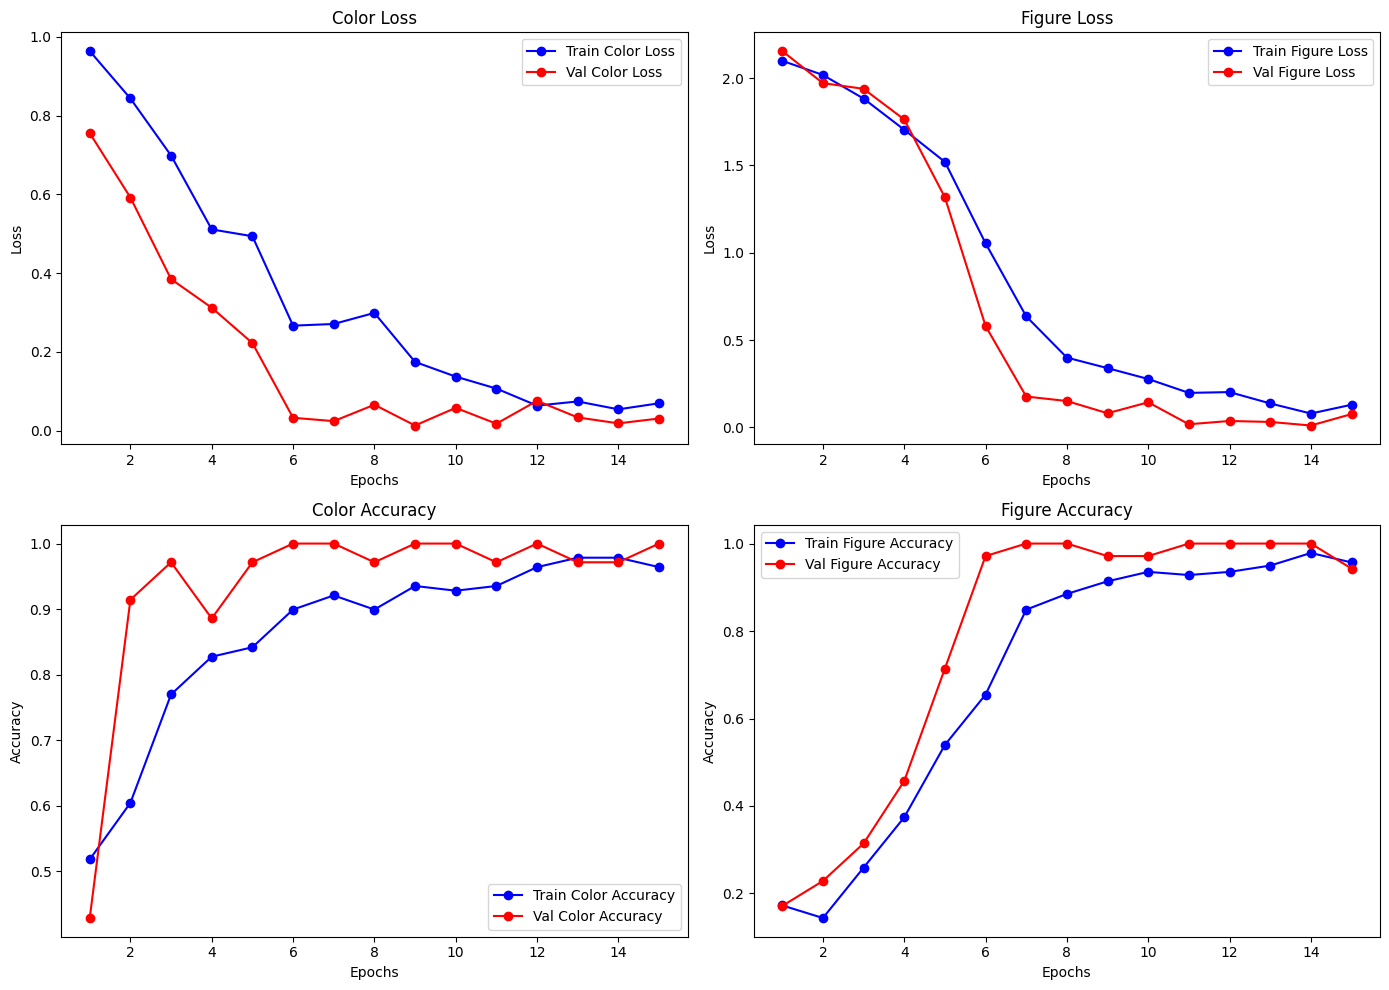

In [16]:
import matplotlib.pyplot as plt

# Данные
train_color_loss = history.history['color_loss']
val_color_loss = history.history['val_color_loss']
train_color_accuracy = history.history['color_accuracy']
val_color_accuracy = history.history['val_color_accuracy']

train_figure_loss = history.history['figure_loss']
val_figure_loss = history.history['val_figure_loss']
train_figure_accuracy = history.history['figure_accuracy']
val_figure_accuracy = history.history['val_figure_accuracy']

epochs = range(1, len(train_color_loss) + 1)

plt.figure(figsize=(14, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_color_loss, 'bo-', label='Train Color Loss')
plt.plot(epochs, val_color_loss, 'ro-', label='Val Color Loss')
plt.title('Color Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_figure_loss, 'bo-', label='Train Figure Loss')
plt.plot(epochs, val_figure_loss, 'ro-', label='Val Figure Loss')
plt.title('Figure Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_color_accuracy, 'bo-', label='Train Color Accuracy')
plt.plot(epochs, val_color_accuracy, 'ro-', label='Val Color Accuracy')
plt.title('Color Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_figure_accuracy, 'bo-', label='Train Figure Accuracy')
plt.plot(epochs, val_figure_accuracy, 'ro-', label='Val Figure Accuracy')
plt.title('Figure Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
